# **Pthreads_report_59**




## **組員與分工**

組員: 林群佑, 刁一平

|      工作項目      |      分工     |
|:-------------------------------------------------:|:-------------:|
|Implement & Experiment & 心得|     林群佑    |
| 心得|     刁一平    |

## Implement

### TSQueue

In [ ]:
#include <pthread.h>
#ifndef TS_QUEUE_HPP
#define TS_QUEUE_HPP
#define DEFAULT_BUFFER_SIZE 200
template <class T>
class TSQueue {
public:
	// constructor
	TSQueue();
	explicit TSQueue(int max_buffer_size);
	// destructor
	~TSQueue();
	// add an element to the end of the queue
	void enqueue(T item);
	// remove and return the first element of the queue
	T dequeue();
	// return the number of elements in the queue
	int get_size();
private:
	// the maximum buffer size
	int buffer_size;
	// the buffer containing values of the queue
	T* buffer;
	// the current size of the buffer
	int size;
	// the index of first item in the queue
	int head;
	// the index of last item in the queue
	int tail;
	// pthread mutex lock
	pthread_mutex_t mutex;
	// pthread conditional variable
	pthread_cond_t cond_enqueue, cond_dequeue;
};

In [ ]:
// Implementation start
template <class T>
TSQueue<T>::TSQueue() : TSQueue(DEFAULT_BUFFER_SIZE) {
}
template <class T>
TSQueue<T>::TSQueue(int buffer_size) : buffer_size(buffer_size) {
	// TODO: implements TSQueue constructor
	tail = head = size = 0;
	buffer = new T[buffer_size];
	pthread_mutex_init(&mutex, nullptr);
  pthread_cond_init(&cond_enqueue, nullptr);
  pthread_cond_init(&cond_dequeue, nullptr);
}

建構子實作

* 設 size, tail, head 為 0
* 根據傳入參數設定 buffer 緩衝大小 ( 若無參數傳入，則使用 DEFAULT_BUFFER_SIZE 200 )
* 初始化 mutex lock ( mutex )
* 初始化 cond lock ( cond_enqueue )
* 初始化 cond lock ( cond_dequeue )



In [ ]:
template <class T>
TSQueue<T>::~TSQueue() {
	// TODO: implenents TSQueue destructor
	delete[] buffer;
	pthread_mutex_destroy(&mutex);
  pthread_cond_destroy(&cond_enqueue);
  pthread_cond_destroy(&cond_dequeue);
}

解建構子實作

* 刪除 buffer
* 刪除 mutex lock ( mutex )
* 刪除 cond lock ( cond_enqueue )
* 刪除 cond lock ( cond_dequeue )

In [ ]:
template <class T>
void TSQueue<T>::enqueue(T item) {
	// TODO: enqueues an element to the end of the queue
	pthread_mutex_lock(&mutex);
  while (size >= buffer_size) {
    pthread_cond_wait(&cond_enqueue, &mutex);
  }
	buffer[tail] = item;
  tail = (tail + 1) % buffer_size;
  ++size;
  pthread_mutex_unlock(&mutex);
  pthread_cond_signal(&cond_dequeue);
}

enqueue 實作

1. 首先要取得 mutex lock 避免 race condition 導致錯誤
2. 使用 while 迴圈檢查當前 buffer 是否仍有空間，這樣能夠避免 thread 在錯誤的時間被呼叫並執行
3. 若空間不足呼叫 pthread_cond_wait(&cond_enqueue, &mutex) 讓當前 thread 進入 wait 狀態並釋放 mutex lock 給其他可能需要的 thread
4. 若緩衝區存在空間，則將其放入緩衝區然後 tail = (tail + 1) % buffer_size 避免超出緩衝區，並將 size + 1
5. 釋放 mutex lock
6. 呼叫 pthread_cond_signal(&cond_dequeue) 呼叫在等待的 thread 開始執行 ( 如果有的話 )

In [ ]:
template <class T>
T TSQueue<T>::dequeue() {
	// TODO: dequeues the first element of the queue
	pthread_mutex_lock(&mutex);
  while (size == 0) {
    pthread_cond_wait(&cond_dequeue, &mutex);
  }
  T item = buffer[head];
  head = (head + 1) % buffer_size;
  --size;
  pthread_mutex_unlock(&mutex);
  pthread_cond_signal(&cond_enqueue);
  return item;
}

dequeue 實作

1. 首先要取得 mutex lock 避免 race condition 導致錯誤
2. 使用 while 迴圈檢查當前 buffer 是否有資料，這樣能夠避免 thread 在錯誤的時間被呼叫並執行
3. 若沒有資料呼叫 pthread_cond_wait(&cond_enqueue, &mutex) 讓當前 thread 進入 wait 狀態並釋放 mutex lock 給其他可能需要的 thread
4. 若存在資料，則將其取出然後 head = (head + 1) % buffer_size 避免超出緩衝區，並將 size - 1
5. 釋放 mutex lock
6. 呼叫 pthread_cond_signal(&cond_enqueue) 呼叫在等待的 thread 開始執行 ( 如果有的話 )

In [ ]:
template <class T>
int TSQueue<T>::get_size() {
	// TODO: returns the size of the queue
	pthread_mutex_lock(&mutex);
  int current_size = size;
  pthread_mutex_unlock(&mutex);
  return current_size;
}
#endif // TS_QUEUE_HPP

get_size 實作

1. 首先要取得 mutex lock 避免 race condition 導致錯誤
2. 取得 size
3. 釋放 mutex lock
4. 返回 size

### Reader

reader 裡面沒有需要實作的部分，故省略

### Writer

In [ ]:
#include <fstream>
#include "thread.hpp"
#include "ts_queue.hpp"
#include "item.hpp"
#ifndef WRITER_HPP
#define WRITER_HPP
class Writer : public Thread {
public:
	// constructor
	Writer(int expected_lines, std::string output_file, TSQueue<Item*>* output_queue);
	// destructor
	~Writer();
	virtual void start() override;
private:
	// the expected lines to write,
	// the writer thread finished after output expected lines of item
	int expected_lines;
	std::ofstream ofs;
	TSQueue<Item*> *output_queue;
	// the method for pthread to create a writer thread
	static void* process(void* arg);
};
// Implementation start
Writer::Writer(int expected_lines, std::string output_file, TSQueue<Item*>* output_queue)
	: expected_lines(expected_lines), output_queue(output_queue) {
	ofs = std::ofstream(output_file);
}
Writer::~Writer() {
	ofs.close();
}

In [ ]:
void Writer::start() {
	// TODO: starts a Writer thread
  if (pthread_create(&t, nullptr, Writer::process, this) != 0) {
    std::cerr << "Failed to create writer thread!" << '\n';
    exit(1);  // Exit if thread creation fails
  }
}

start 實作

* 創造一個新  user thread 執行 Writer::process 的程式
* 如果創造失敗輸出 Failed to create writer thread! 並結束程式

In [ ]:
void* Writer::process(void* arg) {
	// TODO: implements the Writer's work
	Writer* writer = static_cast<Writer*>(arg);
  int lines_written = 0;
  // Process items until the expected number of lines is written
  while (lines_written < writer->expected_lines) {
    Item* item = writer->output_queue->dequeue();
    writer->ofs << item->key << " " << item->val << " " << item->opcode << '\n';
    ++lines_written;
    delete item;
  }
  return nullptr;
}
#endif // WRITER_HPP

process 實作

1. 首先 static_cast 將傳入的參數 arg 轉換為 Writer* 型別的指標
2. 然後重複將 writer->output_queue 內的 Item 取出並寫入指定目標文件內 ( 使用writer->ofs 向指定文件寫入 )，直到達到目標行數後停止


### Producer

In [ ]:
#include <pthread.h>
#include "thread.hpp"
#include "ts_queue.hpp"
#include "item.hpp"
#include "transformer.hpp"
#ifndef PRODUCER_HPP
#define PRODUCER_HPP
class Producer : public Thread {
public:
	// constructor
	Producer(TSQueue<Item*>* input_queue, TSQueue<Item*>* worker_queue, Transformer* transfomrer);

	// destructor
	~Producer();

	virtual void start();
private:
	TSQueue<Item*>* input_queue;
	TSQueue<Item*>* worker_queue;

	Transformer* transformer;

	// the method for pthread to create a producer thread
	static void* process(void* arg);
};
Producer::Producer(TSQueue<Item*>* input_queue, TSQueue<Item*>* worker_queue, Transformer* transformer)
	: input_queue(input_queue), worker_queue(worker_queue), transformer(transformer) {
}
Producer::~Producer() {}

In [ ]:
void Producer::start() {
	// TODO: starts a Producer thread
	pthread_create(&t, nullptr, Producer::process, this);
}

start 實作

* 創造一個新  user thread 執行 Producer::process 的程式

In [ ]:
void* Producer::process(void* arg) {
	// TODO: implements the Producer's work
	Producer* producer = static_cast<Producer*>(arg);
  while (true) {
    // Dequeue item from the input queue
    Item* item = producer->input_queue->dequeue();
    // Apply the transformation to the item
    item->val=item->val=producer->transformer->producer_transform(item->opcode,item->val);
    // Enqueue the transformed item to the worker queue
    producer->worker_queue->enqueue(item);
  }
  return nullptr; // Return null since it's a void* return type for the thread
}
#endif // PRODUCER_HPP

process 實作

1. 首先 static_cast 將傳入的參數 arg 轉換為 Producer* 型別的指標
2. 然後重複讀取 Item ，接著執行 producer->transformer->producer_transform 執行指定轉換，完成後將 Item 放入 producer->worker_queue

### Consumer

In [ ]:
#include <pthread.h>
#include <stdio.h>
#include "thread.hpp"
#include "ts_queue.hpp"
#include "item.hpp"
#include "transformer.hpp"
#ifndef CONSUMER_HPP
#define CONSUMER_HPP
class Consumer : public Thread {
public:
	// constructor
	Consumer(TSQueue<Item*>* worker_queue, TSQueue<Item*>* output_queue, Transformer* transformer);
	// destructor
	~Consumer();
	virtual void start() override;
	virtual int cancel() override;
private:
	TSQueue<Item*>* worker_queue;
	TSQueue<Item*>* output_queue;
	Transformer* transformer;
	bool is_cancel;
	// the method for pthread to create a consumer thread
	static void* process(void* arg);
};
Consumer::Consumer(TSQueue<Item*>* worker_queue, TSQueue<Item*>* output_queue, Transformer* transformer)
	: worker_queue(worker_queue), output_queue(output_queue), transformer(transformer) {
	is_cancel = false;
}

Consumer::~Consumer() {}

In [ ]:
void Consumer::start() {
	// TODO: starts a Consumer thread
	pthread_create(&t, nullptr, Consumer::process, this);
}

start 實作

* 創造一個新  user thread 執行 Consumer::process 的程式

In [ ]:
int Consumer::cancel() {
	// TODO: cancels the consumer thread
	is_cancel = true;
	return pthread_cancel(t);
}

cancel 實作

* 設 is_cancel 為 true
* 呼叫 pthread_cancel(t) 取消當前線程

In [ ]:
void* Consumer::process(void* arg) {
	Consumer* consumer = (Consumer*)arg;
	pthread_setcanceltype(PTHREAD_CANCEL_DEFERRED, nullptr); //使用 PTHREAD_CANCEL_DEFERRED 使其不會在錯誤時機被 cancel
	while (!consumer->is_cancel) {
		pthread_setcancelstate(PTHREAD_CANCEL_DISABLE, nullptr); //代表此時之後不可以被 cancel
		// TODO: implements the Consumer's work
		Item* item = consumer->worker_queue->dequeue();
    // Process the item using the consumer's transformer
    item->val=consumer->transformer->consumer_transform(item->opcode,item->val);
    // Put the processed item into the output queue
    consumer->output_queue->enqueue(item);
		pthread_setcancelstate(PTHREAD_CANCEL_ENABLE, nullptr); //代表此時之後可以被 cancel
	}
	return nullptr;
}
#endif // CONSUMER_HPP

process 實作

1. 首先 static_cast 將傳入的參數 arg 轉換為 Consumer* 型別的指標
2. 從 consumer->worker_queue 取出 Item
3. 使用 consumer->transformer->consumer_transform 進行轉換
4. 將 Item 放入 consumer->output_queue
5. 不停重複 2 到 4 步驟直到 consumer->is_cancel 被設為 true 要退出時

### ConsumerController

In [ ]:
#include <pthread.h>
#include <unistd.h>
#include <vector>
#include <iostream>
#include "consumer.hpp"
#include "ts_queue.hpp"
#include "item.hpp"
#include "transformer.hpp"
#ifndef CONSUMER_CONTROLLER
#define CONSUMER_CONTROLLER
class ConsumerController : public Thread {
public:
	// constructor
	ConsumerController(
		TSQueue<Item*>* worker_queue,
		TSQueue<Item*>* writer_queue,
		Transformer* transformer,
		int check_period,
		int low_threshold,
		int high_threshold
	);
	// destructor
	~ConsumerController();
	virtual void start();
private:
	std::vector<Consumer*> consumers;
	TSQueue<Item*>* worker_queue;
	TSQueue<Item*>* writer_queue;
	Transformer* transformer;
	// Check to scale down or scale up every check period in microseconds.
	int check_period;
	// When the number of items in the worker queue is lower than low_threshold,
	// the number of consumers scaled down by 1.
	int low_threshold;
	// When the number of items in the worker queue is higher than high_threshold,
	// the number of consumers scaled up by 1.
	int high_threshold;
	static void* process(void* arg);
};
// Implementation start
ConsumerController::ConsumerController(
	TSQueue<Item*>* worker_queue,
	TSQueue<Item*>* writer_queue,
	Transformer* transformer,
	int check_period,
	int low_threshold,
	int high_threshold
) : worker_queue(worker_queue),
	writer_queue(writer_queue),
	transformer(transformer),
	check_period(check_period),
	low_threshold(low_threshold),
	high_threshold(high_threshold){
}
ConsumerController::~ConsumerController() {}

In [ ]:
void ConsumerController::start() {
	// TODO: starts a ConsumerController thread
	pthread_create(&t, nullptr, ConsumerController::process, this);
}

start 實作

* 創造一個新  user thread 執行 Consumer::process 的程式

In [ ]:
void* ConsumerController::process(void* arg) {
	// TODO: implements the ConsumerController's work
	ConsumerController* controller = (ConsumerController*)arg;  // Cast the argument to ConsumerController*
	pthread_setcanceltype(PTHREAD_CANCEL_DEFERRED, nullptr);
  while (true) {
    usleep(controller->check_period);  // Sleep for the check period
		pthread_setcancelstate(PTHREAD_CANCEL_DISABLE, nullptr);
    // Check the size of the worker queue
    int queue_size = controller->worker_queue->get_size();
    // Scale up (add consumers) if needed
    if (queue_size > controller->high_threshold ) {
      Consumer* new_consumer = new Consumer(controller->worker_queue, controller->writer_queue, controller->transformer);
      new_consumer->start();
      controller->consumers.push_back(new_consumer);
      std::cout<< "Scaling up consumers from "<<controller->consumers.size()-1<<" to "<<controller->consumers.size()<<'\n';
    }
    if (queue_size < controller->low_threshold && controller->consumers.size() > 1) {
      Consumer* consumer_to_remove = controller->consumers.back();
      controller->consumers.pop_back();
      consumer_to_remove->cancel();
		  consumer_to_remove->join();
		  delete consumer_to_remove;
      std::cout<<"Scaling down consumers from "<<controller->consumers.size()+1<<" to "<<controller->consumers.size()<<'\n';
    }
		pthread_setcancelstate(PTHREAD_CANCEL_ENABLE, nullptr);
  }
  return nullptr;  // Exit the process thread
}
#endif // CONSUMER_CONTROLLER_HPP

process 實作

1. 首先 static_cast 將傳入的參數 arg 轉換為 ConsumerController* 型別的指標
2. 呼叫 pthread_setcanceltype(PTHREAD_CANCEL_DEFERRED, nullptr) 使其不會在錯誤時機被取消
3. 呼叫 usleep 使當前程式停止 controller->check_period 毫秒
4. 呼叫 pthread_setcancelstate(PTHREAD_CANCEL_DISABLE, nullptr) 進入重要區域無法被 cancel
5. 取得 controller->worker_queue 的 size
6. 當 controller->worker_queue 的 size 大於 controller->high_threshold 的標準時，執行下面 4 個步驟
  1. 創造一個新 Consumer
  2. 呼叫 new_consumer->start() 執行新 Consumer
  3. 將新 Consumer 放入 controller->consumers 統一管理
  4. 輸出訊息告知新增 Consumer
7. 當 controller->worker_queue 的 size 小於 controller->low_threshold 以及目前至少存在超過 1 個 consumer threads 的時候，執行下面 5 個步驟
  1. 取出 controller->consumers 中管理的最後一個 consumer thread
  2. 呼叫 cancel 取消這個 consumer thread
  3. 呼叫 join 確認 consumer thread 完全停止
  4. 使用 delete 刪除這個 consumer thread
  5. 輸出訊息告知減少 Consumer
8. 呼叫 pthread_setcancelstate(PTHREAD_CANCEL_ENABLE, nullptr) 使其可以被取消
9. 無限重複步驟 3 到 8

### Main

In [ ]:
#include <assert.h>
#include <stdlib.h>
#include "ts_queue.hpp"
#include "item.hpp"
#include "reader.hpp"
#include "writer.hpp"
#include "producer.hpp"
#include "consumer_controller.hpp"
#define READER_QUEUE_SIZE 200
#define WORKER_QUEUE_SIZE 200
#define WRITER_QUEUE_SIZE 4000
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 20
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 80
#define CONSUMER_CONTROLLER_CHECK_PERIOD 1000000
int main(int argc, char** argv) {
	assert(argc == 4);
	int n = atoi(argv[1]);
	std::string input_file_name(argv[2]);
	std::string output_file_name(argv[3]);
	// TODO: implements main function
	TSQueue<Item*>* reader_queue = new TSQueue<Item*>(READER_QUEUE_SIZE);
  TSQueue<Item*>* worker_queue = new TSQueue<Item*>(WORKER_QUEUE_SIZE);
  TSQueue<Item*>* writer_queue = new TSQueue<Item*>(WRITER_QUEUE_SIZE);
  Transformer* transformer = new Transformer();
  Reader* reader = new Reader(n, input_file_name, reader_queue);
  Writer* writer = new Writer(n, output_file_name, writer_queue);
  ConsumerController* consumer_controller = new ConsumerController(
    worker_queue,
    writer_queue,
    transformer,
    CONSUMER_CONTROLLER_CHECK_PERIOD,
    (WORKER_QUEUE_SIZE*CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE/100),//將百分比轉換為實際大小
    (WORKER_QUEUE_SIZE*CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE/100)
  );
  Producer* producers[4];
  for(int i=0;i<4;++i){
    producers[i] = new Producer(reader_queue, worker_queue, transformer);
    producers[i]->start();
  }
  consumer_controller->start();
  writer->start();
  reader->start();
  reader->join();
  writer->join();
  delete reader;
  delete writer;
  for(int i=0;i<4;++i) delete producers[i];
  delete consumer_controller;
  delete transformer;
  delete reader_queue;
  delete worker_queue;
  delete writer_queue;
	return 0;
}

main 實作
1. 新增 reader_queue, worker_queue, writer_queue 3個 TSQueue<Item * > *
2. 新增 reader, writer, ConsumerController 函式
3. 新增 4 個 producer 並開始執行
4. 開始執行 reader, writer, ConsumerController
5. 呼叫 join 函示等待 reader, writer 執行完成
6. 由於 reader, writer, consumer, producer 此時已經不會動了( 由於沒有資料所以卡在 TSQueue 取不出資料被 blocked 住 )，若要 join 或 cancel 得改架構，使其能夠跳出 TSQueue 不然就是設計 kill 函式直接調用 pthread_kill 直接砍掉，但目前而言我們完全可以確認這些皆不會執行，直接刪除基本上不會引發問題
7. 將所有物件刪除釋放內存空間
8. 返回 0 結束執行

## Experiment

### 我透過編寫自動化腳本來幫助我完成觀察不同的設定在執行提供的 test00 跟 test01 所造成的差別

In [ ]:
#!/bin/bash
echo "Running auto_gen_transformer..."
./scripts/auto_gen_transformer --input ./tests/00_spec.json --output transformer.cpp
echo "Running make clean..."
make clean
echo "Running make with devtoolset-8..."
scl enable devtoolset-8 'make'
echo "Running main with parameters 200 ./tests/00.in ./tests/00.out..."
time ./main 200 ./tests/00.in ./tests/00.out
echo "Running verify script..."
./scripts/verify --output ./tests/00.out --answer ./tests/00.ans
echo "All steps completed."

以上是測試 test00 的腳本

In [ ]:
#!/bin/bash
echo "Running auto_gen_transformer..."
./scripts/auto_gen_transformer --input ./tests/01_spec.json --output transformer.cpp
echo "Running make clean..."
make clean
echo "Running make with devtoolset-8..."
scl enable devtoolset-8 'make'
echo "Running main with parameters 4000 ./tests/01.in ./tests/01.out..."
time ./main 4000 ./tests/01.in ./tests/01.out
echo "Running verify script..."
./scripts/verify --output ./tests/01.out --answer ./tests/01.ans
echo "All steps completed."

以上是測試 test01 的腳本

### 然而上述兩筆提供測資對於 consumer 與 producer 負擔較為平均，對於部分測試較為不敏感，不易了解到區別，所以我編寫一個我自己的測資 test02 進行測試，同樣使用 auto_gen_transformer 來生成 transformer.cpp 故下方提供我編寫的 .json 檔與測資說明

In [ ]:
#!/bin/bash
echo "Running auto_gen_transformer..."
./scripts/auto_gen_transformer --input ./tests/02_spec.json --output transformer.cpp
echo "Running make clean..."
make clean
echo "Running make with devtoolset-8..."
scl enable devtoolset-8 'make'
echo "Running main with parameters 30000 ./tests/02.in ./tests/02.out..."
time ./main 30000 ./tests/02.in ./tests/02.out
echo "All steps completed."

以上是測試 test02 的腳本

In [ ]:
{
	"n": 30000,
	"input": "./tests/00.in",
	"output": "./tests/00.out",
	"auto_gen_transformer": {
		"annotation": {
			"A": "same speed",
			"B": "producer faster than consumer",
			"C": "consumer faster than producer"
		},
		"producer": {
			"A": {
				"a": 11,
				"b": 1111,
				"m": 1000000007,
				"iterations": 1
			},
			"B": {
				"a": 13,
				"b": 1313,
				"m": 1000000007,
				"iterations": 1
			},
			"C": {
				"a": 17,
				"b": 1717,
				"m": 1000000007,
				"iterations": 2000000
			}
		},
		"consumer": {
			"A": {
				"a": 19,
				"b": 1919,
				"m": 1000000007,
				"iterations": 1
			},
			"B": {
				"a": 23,
				"b": 2323,
				"m": 1000000007,
				"iterations": 2000000
			},
			"C": {
				"a": 29,
				"b": 2929,
				"m": 1000000007,
				"iterations": 1
			}
		}
	},
	"auto_gen_input": {
		"low": 0,
		"high": 123456,
		"choices": {
			"200": ["A", "B", "C"]
		}
	}
}

以上是 02_spec.json

而測資是先一萬筆 A ，然後一萬筆 B ，最後一萬筆 C ，共三萬筆

### Default setting

In [ ]:
#define READER_QUEUE_SIZE 200
#define WORKER_QUEUE_SIZE 200
#define WRITER_QUEUE_SIZE 4000
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 20
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 80
#define CONSUMER_CONTROLLER_CHECK_PERIOD 1000000

上面是 default 的各種參數設定

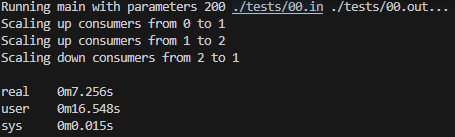

上面是 test00 的執行時間資訊

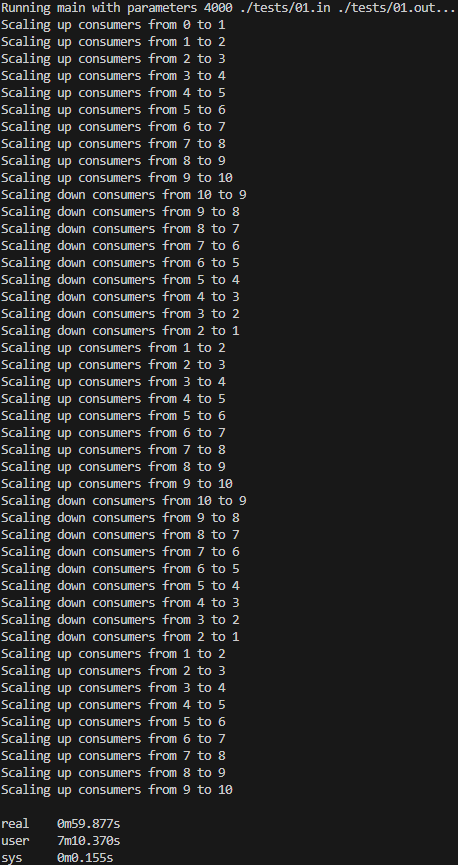

上面是 test01 的執行時間資訊

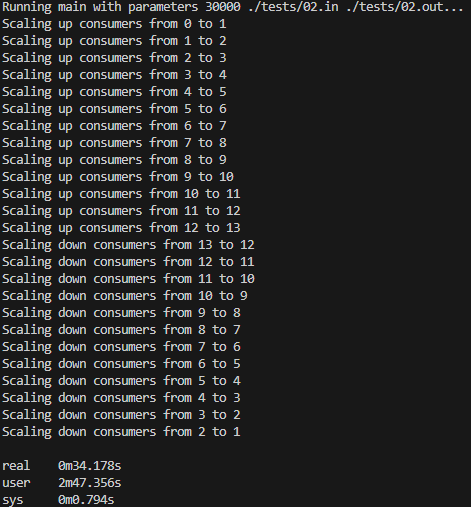

上面是 test02 的執行時間資訊

### Different values of CONSUMER_CONTROLLER_CHECK_PERIOD

#### CONSUMER_CONTROLLER_CHECK_PERIOD 變為 default 的十分之一

In [ ]:
#define READER_QUEUE_SIZE 200
#define WORKER_QUEUE_SIZE 200
#define WRITER_QUEUE_SIZE 4000
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 20
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 80
#define CONSUMER_CONTROLLER_CHECK_PERIOD 100000

CONSUMER_CONTROLLER_CHECK_PERIOD 變為 default 的十分之一的參數

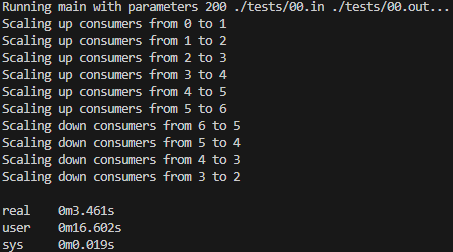

上面是 test00 的執行時間資訊

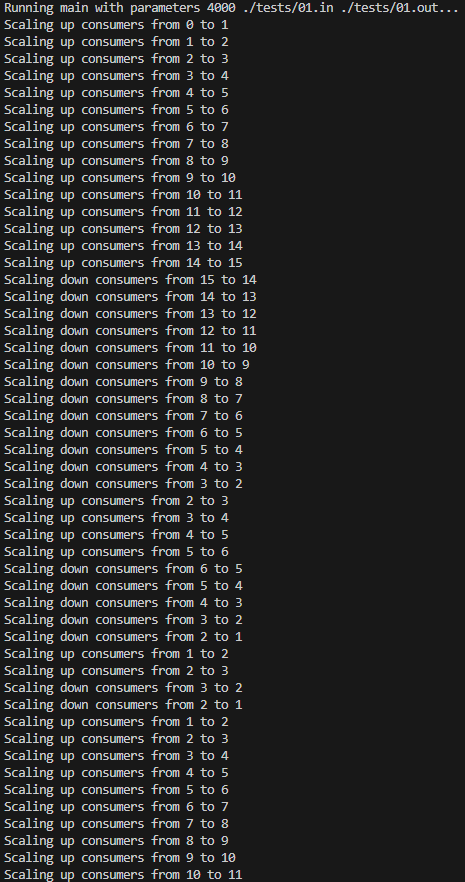

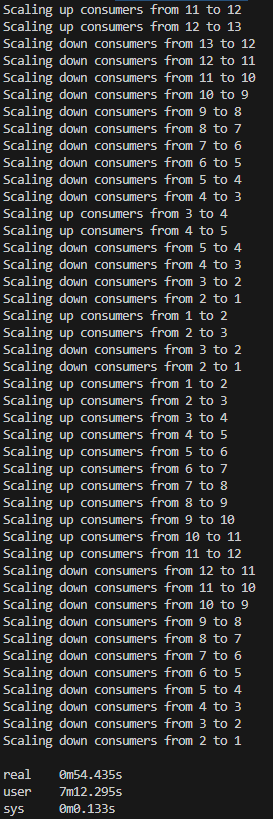

上面是 test01 的執行時間資訊




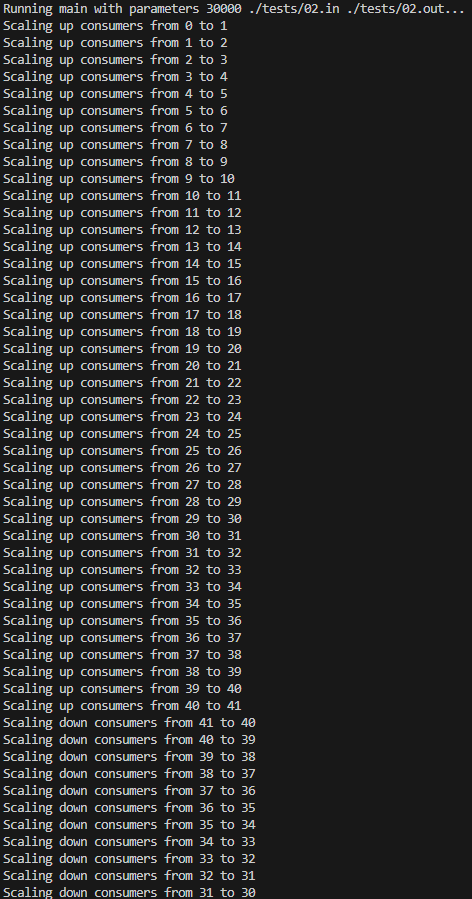

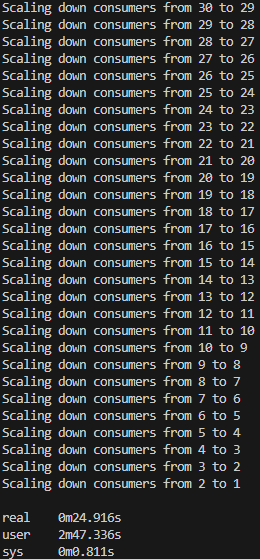

上面是 test02 的執行時間資訊

#### CONSUMER_CONTROLLER_CHECK_PERIOD 變為原來的十倍

In [ ]:
#define READER_QUEUE_SIZE 200
#define WORKER_QUEUE_SIZE 200
#define WRITER_QUEUE_SIZE 4000
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 20
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 80
#define CONSUMER_CONTROLLER_CHECK_PERIOD 10000000

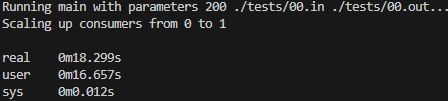

上面是 test00 的執行時間資訊

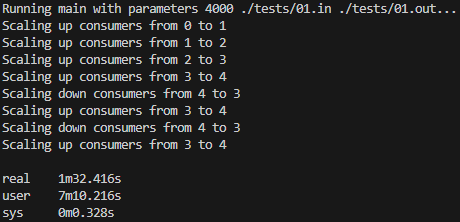

上面是 test01 的執行時間資訊

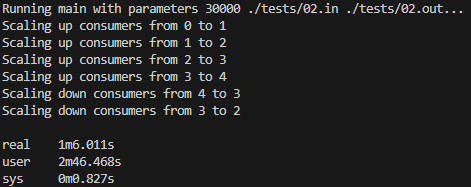

上面是 test02 的執行時間資訊

#### 回答

綜合上方測驗，我們可以發現 user time 其實差不了太多 ( 計算總共需要的時間是差不多的，只是看使用多少 threads ) ，基本上算是 CPU 附載調度等造成的誤差，而在 real time 可以看到較為明顯的差別， CONSUMER_CONTROLLER_CHECK_PERIOD 較短能夠在短時間調度更多 consumer 出來處理 producer 快於 consumer 的測資，增加程式平行化的程度 ( 當然前提是有足夠多 physical threads 能夠調度 )

### Different values of CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE and CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE

#### 同時降低 CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 與提高 CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 百分之10

In [ ]:
#define READER_QUEUE_SIZE 200
#define WORKER_QUEUE_SIZE 200
#define WRITER_QUEUE_SIZE 4000
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 30
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 70
#define CONSUMER_CONTROLLER_CHECK_PERIOD 1000000

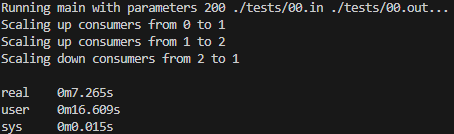

上面是 test00 的執行時間資訊

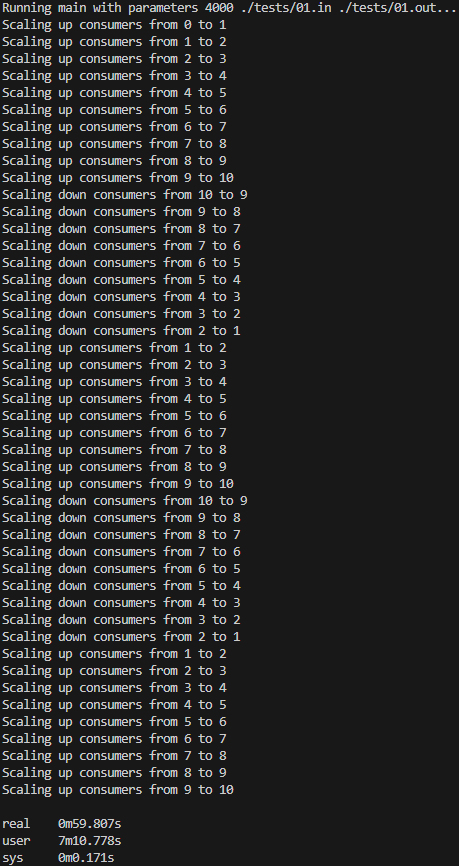

上面是 test01 的執行時間資訊

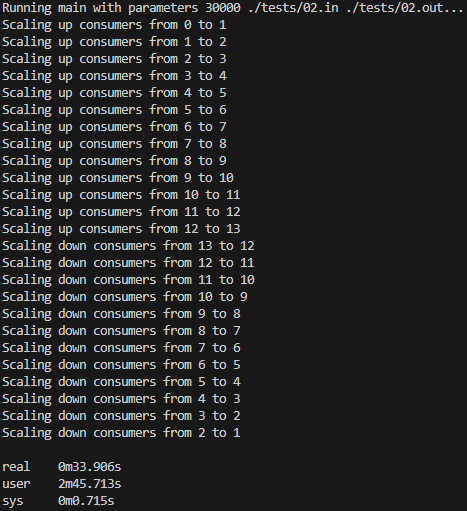

上面是 test02 的執行時間資訊

#### 同時提高 CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 與降低 CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 百分之10

In [ ]:
#define READER_QUEUE_SIZE 200
#define WORKER_QUEUE_SIZE 200
#define WRITER_QUEUE_SIZE 4000
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 10
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 90
#define CONSUMER_CONTROLLER_CHECK_PERIOD 1000000

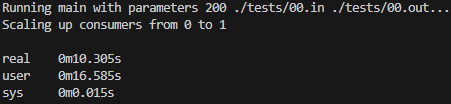

上面是 test00 的執行時間資訊

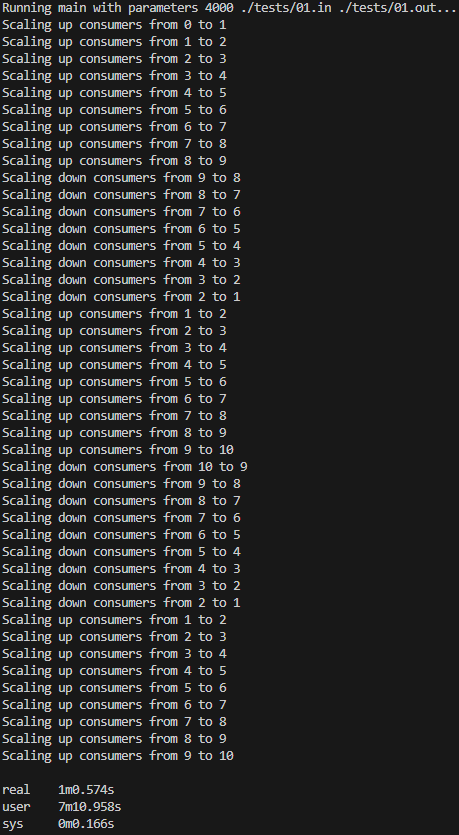

上面是 test01 的執行時間資訊

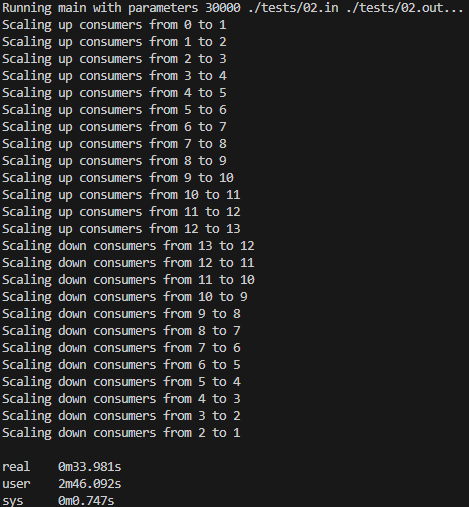

上面是 test02 的執行時間資訊

#### 只提高 CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 百分之10

In [ ]:
#define READER_QUEUE_SIZE 200
#define WORKER_QUEUE_SIZE 200
#define WRITER_QUEUE_SIZE 4000
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 30
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 80
#define CONSUMER_CONTROLLER_CHECK_PERIOD 1000000

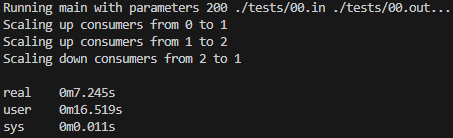

上面是 test00 的執行時間資訊

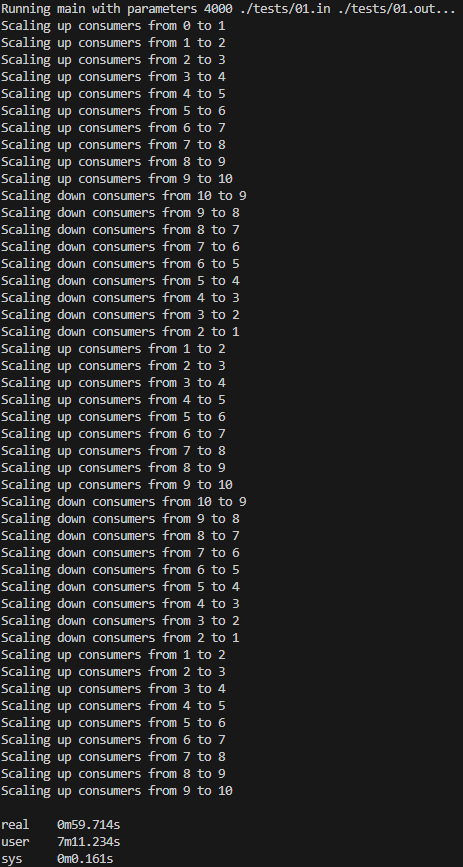

上面是 test01 的執行時間資訊

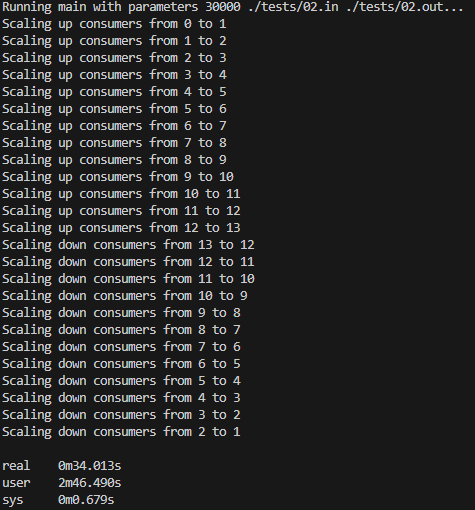

上面是 test02 的執行時間資訊

#### 只降低 CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 百分之10

In [ ]:
#define READER_QUEUE_SIZE 200
#define WORKER_QUEUE_SIZE 200
#define WRITER_QUEUE_SIZE 4000
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 20
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 70
#define CONSUMER_CONTROLLER_CHECK_PERIOD 1000000

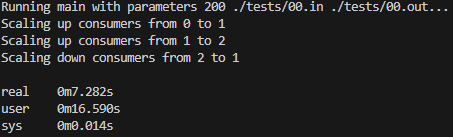

上面是 test00 的執行時間資訊

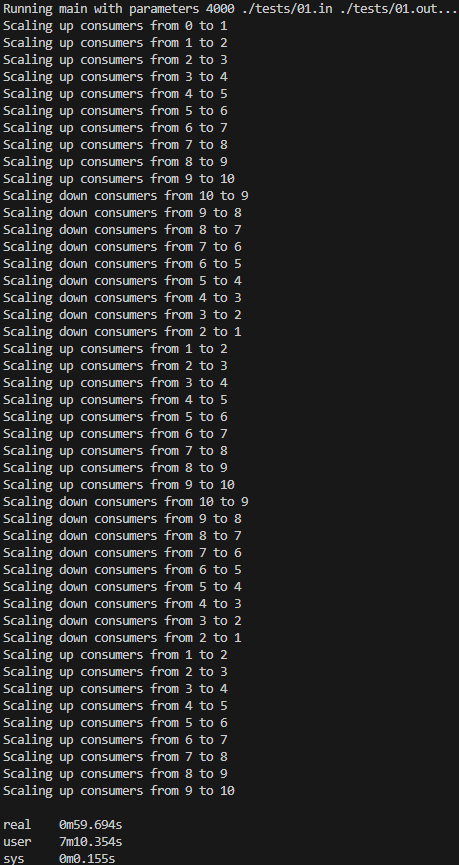

上面是 test01 的執行時間資訊

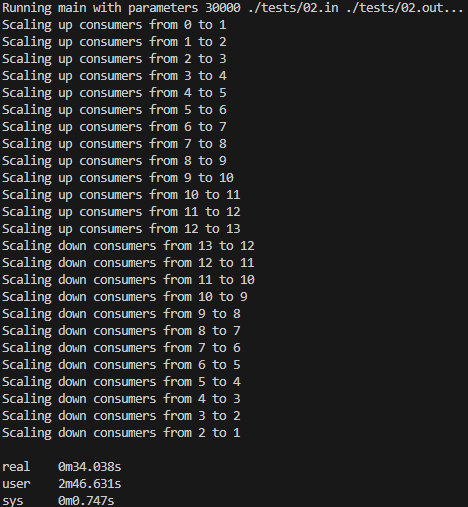

上面是 test02 的執行時間資訊

#### 回答

從上面的數據我們可以看到對於突然的峰值出現 ( 突然出現大量 producer 快於 consumer 的工作或大量 consumer 快於 producer )，不論如何調整，效果皆有限 ( real time 差不多 )，主要可能還是得依靠更短的更新頻率，才能有效應對峰值得出現

### Different values of WORKER_QUEUE_SIZE

#### WORKER_QUEUE_SIZE 變為 default 的十分之一

In [ ]:
#define READER_QUEUE_SIZE 200
#define WORKER_QUEUE_SIZE 20
#define WRITER_QUEUE_SIZE 4000
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 20
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 80
#define CONSUMER_CONTROLLER_CHECK_PERIOD 1000000

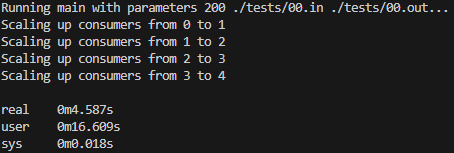

上面是 test00 的執行時間資訊

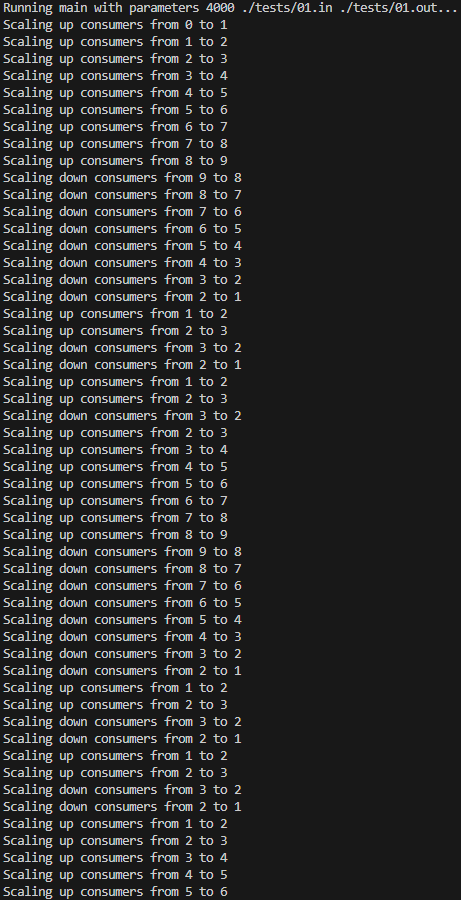

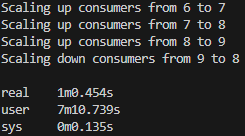

上面是 test01 的執行時間資訊

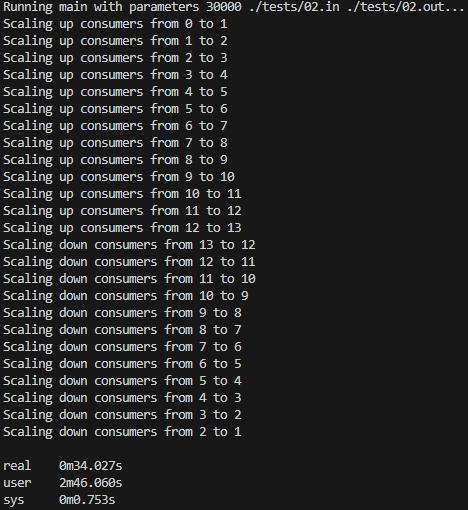

上面是 test02 的執行時間資訊

#### WORKER_QUEUE_SIZE 變為 default 的十倍

In [ ]:
#define READER_QUEUE_SIZE 200
#define WORKER_QUEUE_SIZE 2000
#define WRITER_QUEUE_SIZE 4000
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 20
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 80
#define CONSUMER_CONTROLLER_CHECK_PERIOD 1000000

由於 test00 才 200 個，達不到 WORKER_QUEUE_SIZE 的百分之 80 不會出現 consumer 會造成程式卡死，故不進行測試

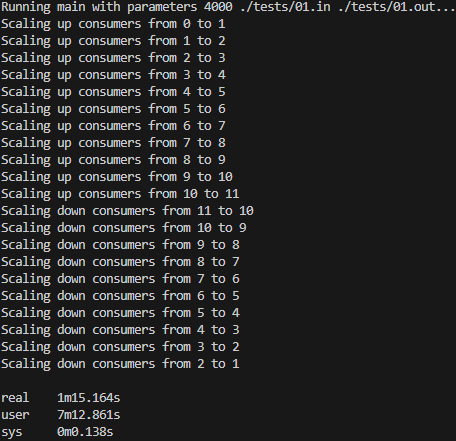

上面是 test01 的執行時間資訊

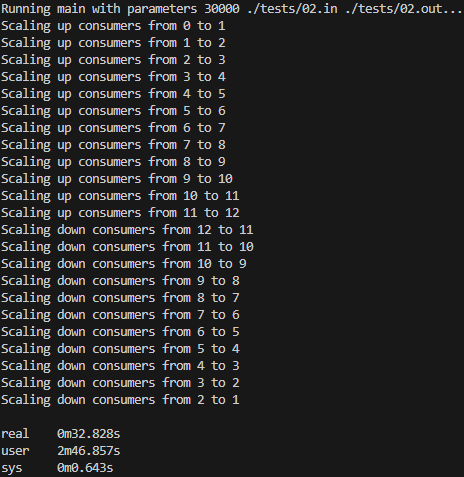

上面是 test02 的執行時間資訊

#### 回答

我們主要可以看到，過大的 worker queue 可能導致 consumer controller 過慢才反應到需要新增更多的 thread 來處理( 從 test01 的 real time 差別我們可以看到較為顯著的差異 )，最後導致程式平行度表現下降

### What happens if WRITER_QUEUE_SIZE is very small

#### 將 writer queue 設為 default 的百分之一

In [ ]:
#define READER_QUEUE_SIZE 200
#define WORKER_QUEUE_SIZE 200
#define WRITER_QUEUE_SIZE 40
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 20
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 80
#define CONSUMER_CONTROLLER_CHECK_PERIOD 1000000

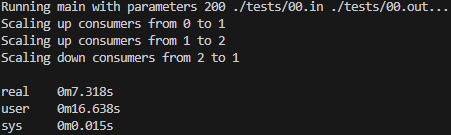

上面是 test00 的執行時間資訊

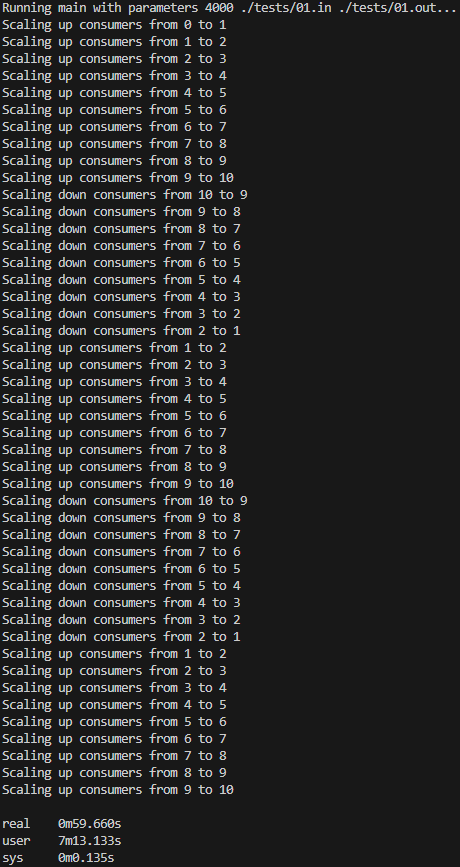

上面是 test01 的執行時間資訊




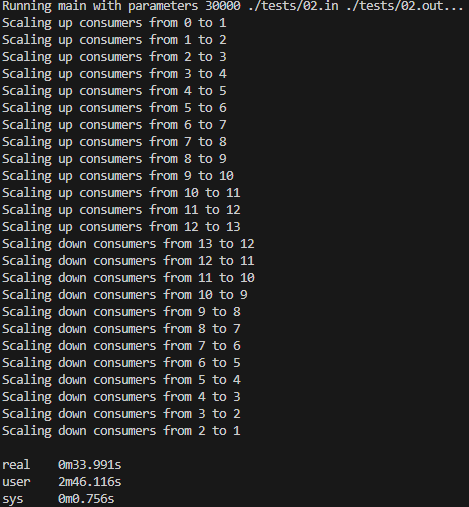

上面是 test02 的執行時間資訊

#### 將 writer queue 設為 1

In [ ]:
#define READER_QUEUE_SIZE 200
#define WORKER_QUEUE_SIZE 200
#define WRITER_QUEUE_SIZE 1
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 20
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 80
#define CONSUMER_CONTROLLER_CHECK_PERIOD 1000000

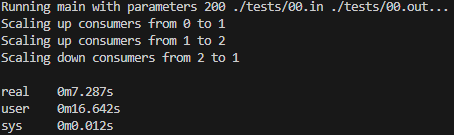

上面是 test00 的執行時間資訊

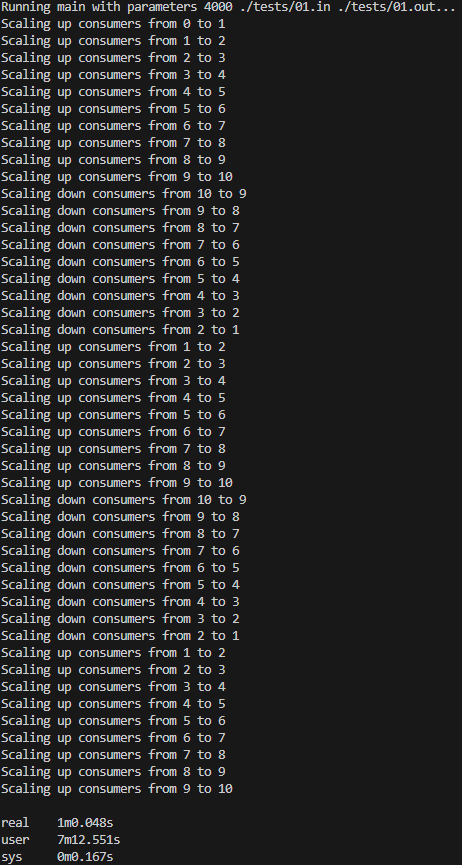

上面是 test01 的執行時間資訊

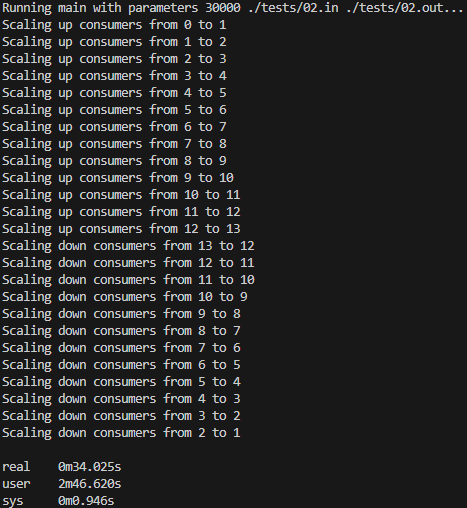

上面是 test02 的執行時間資訊

#### 回答

基本上我們可以看到 writer queue 大小不太容易拖累程式表現，但我們也可以發現在 test02 的 system time 當 writer queue 大小為一時有較為顯著增加 ( 相較於 default ) ，也就是說 consumer 應該有更大機率會進入 condition wait 理論上來說會拖累程式效率，但由於測資設計大部分是計算密集型，多個 consumers 並不容易在同一時間爭搶 writer 的 IO 資源，造成效率低下，但對於更大規模密集 IO 的測資可能影響會更為明顯

### What happens if READER_QUEUE_SIZE is very small?

#### 將 READER_QUEUE_SIZE 設為 default 的十分之一

In [ ]:
#define READER_QUEUE_SIZE 20
#define WORKER_QUEUE_SIZE 200
#define WRITER_QUEUE_SIZE 4000
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 20
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 80
#define CONSUMER_CONTROLLER_CHECK_PERIOD 1000000

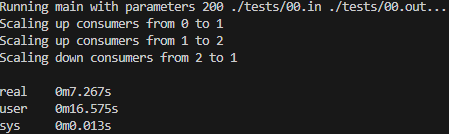

上面是 test00 的執行時間資訊

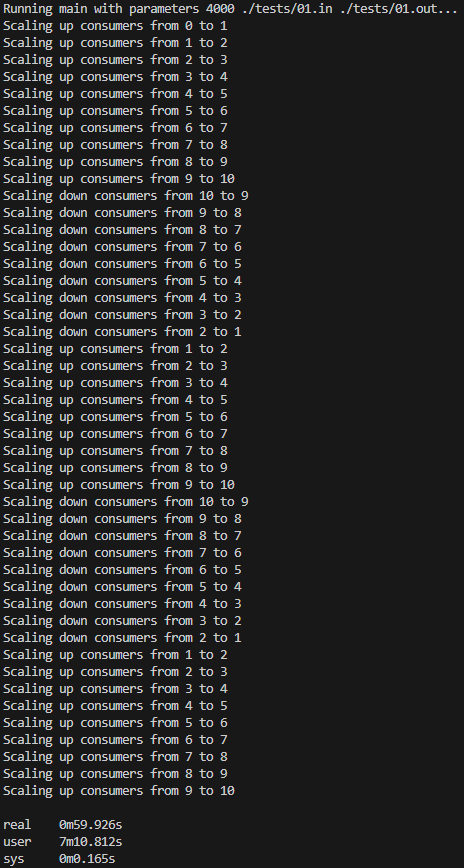

上面是 test01 的執行時間資訊

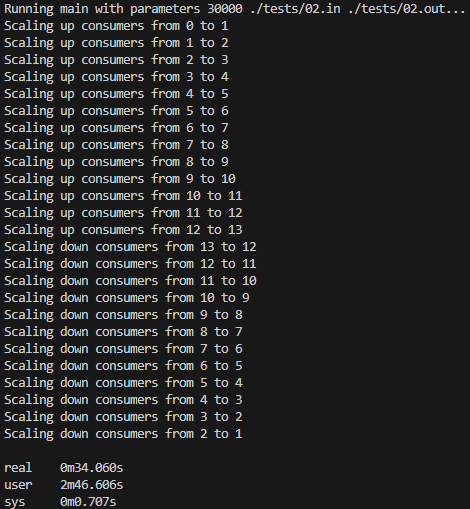

上面是 test02 的執行時間資訊

#### 將 READER_QUEUE_SIZE 設為 1

In [ ]:
#define READER_QUEUE_SIZE 1
#define WORKER_QUEUE_SIZE 200
#define WRITER_QUEUE_SIZE 4000
#define CONSUMER_CONTROLLER_LOW_THRESHOLD_PERCENTAGE 20
#define CONSUMER_CONTROLLER_HIGH_THRESHOLD_PERCENTAGE 80
#define CONSUMER_CONTROLLER_CHECK_PERIOD 1000000

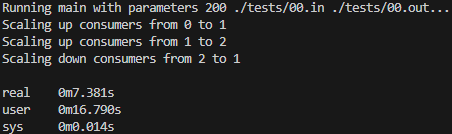

上面是 test00 的執行時間資訊




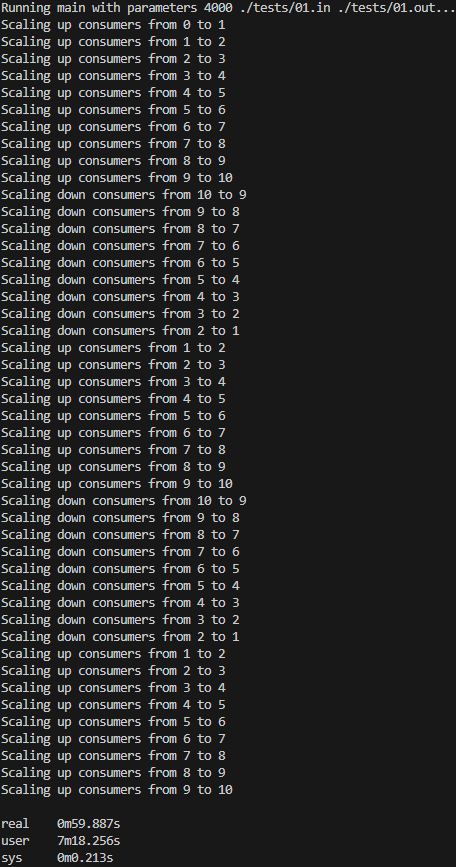

上面是 test01 的執行時間資訊

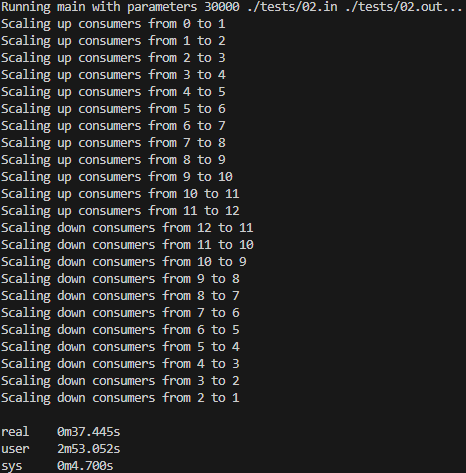

上面是 test02 的執行時間資訊

#### 回答

在 test02 的測資中我們可以發現當 reader size 為一時 system time 有非常顯著的增加 ( 相較於 default ) ，過小的 reader queue 大小會較大程度上的拖累程式表現，由於 producer 固定是四個，多數時間會進入 condition wait 然後等待 reader 完成讀取後 signal ，導致 system call 開銷偏大，影響程式效率

## 心得

* 林群佑

  在實作過程中遇上許多問題，比如說我想嘗試 cancel consumer controller 並等待 join 畢竟隨意刪除 thread 可能引發內存錯誤等問題，但最後我才發現會卡在 TSQueue 裡面出不來，自然等不到被取消然後 join 的時候，程式的除錯也相較於一般單線程程式更難完成，最後測試實驗的部分也還蠻花時間的，但也體驗了一把線程撕裂者真好玩 ( 在測 CONSUMER_CONTROLLER_CHECK_PERIOD 縮短時，能夠調度的線程是真的多，跑得真快 )

* 刁一平


  這次作業後，我對pthreads有了更深的理解，尤其是使用 pthreads 實現
synchronization與communication。此外也能夠讓我學到如何設計TSQueue，以及動態調整 Consumer 數量來平衡效能與資源。
